<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_Atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieves HAFS-A data from AWS along a storm's track using files generated by getStormTrack.ipynb.

#Set up environment

In [1]:
!pip install cfgrib
!pip install cartopy
!pip install tropycal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 56.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tropycal: filename=tropycal-1.3-py3-none-any.whl size=242631 sha256=dd28255479c903fe68f7a85a605cf04604abab50ff7c1936ad3ef91e5a00d57a
  Stored in directory: /root/.cache/pip/wheels/45/b3/db/78c9a2a51e8db2d962647d8dd0bb4e1ed5e1005254353de4af
Successfully built tropycal


In [2]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cft

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


User parameters

In [4]:
name = "Milton"
tcNum = "14"
filepath = f"/content/drive/MyDrive/savedData/{name}"
trackType = ""

runHours = [0, 12] # Which runs to plot, by hour of run

#Retrieve Data

Open TC Data

In [6]:
tc = pd.read_csv(filepath + "/hurdat2_" + name + trackType + ".csv")

Retrieve HAFS-A Atmospheric Data

In [7]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = tc.time[0]
startDate, startTime = start.split(" ")
startYear, startMonth, startDay = startDate.split("-")
startHour, startMinute, startSecond = startTime.split(":")

end = tc.time[len(tc)-1]
endDT = dt.strptime(end, dateFormat)
endDate, endTime = end.split(" ")
endYear, endMonth, endDay = endDate.split("-")
endHour, endMinute, endSecond = endTime.split(":")

Determine times needed

In [8]:
bucket = "https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/"

fcastTimes = {} #Key: initiation, item: Forecast Hour

for row in tc.iloc:
  fcastTimes[row.time] = []
  rowTime = dt.strptime(row.time, dateFormat)
  if rowTime.hour not in runHours or rowTime.minute != 0: continue #Skip any lines that don't have a HAFS forecast at the same time

  for fhour in range(0, 127, 3):
    valid = rowTime + pd.Timedelta(hours=fhour)
    if valid <= endDT:
      fcastTimes[row.time].append(fhour)

Get MSLP data from ATCF files.
(Format described [here](https://science.nrlmry.navy.mil/atcf/docs/database/new/abdeck.txt))

In [9]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]
#"USERDEFINED3", "userdata3", "USERDEFINED4", "userdata4", "USERDEFINED5", "userdata5",
#Sample ATCF URL: https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.trak.atcfunix

In [10]:
stormFiles = []
stormMSLP = {} #Stores pressure along TC track for all forecast hours
stormVmax=  {}
stormLat = {}
stormLon = {}

for init, fhourList in fcastTimes.items():

  initDate, initTime = init.split(" ")
  initYear, initMonth, initDay = initDate.split("-")
  initHour, initMinute, initSecond = initTime.split(":")

  dateStr = initDate.replace("-", "")
  runStr = dateStr + initHour

  stormURL = bucket + dateStr + "/" + initHour + "/" + tcNum + "l." + dateStr + initHour + ".hfsa.trak.atcfunix"
  stormFile = "atcf_" + dateStr + "_" + initHour + ".csv"
  stormFiles.append(stormFile)

  !wget -O {stormFile} {stormURL}
  stormData = pd.read_csv(stormFile, names=cols)
  if len(stormData)==0: continue #ATCF file doesn't exist

  #for row in stormData.iloc:
  for fHour in fhourList:

    valid = stormData[stormData.TAU == fHour].iloc[0] #Files have duplicate forecast hours
    validDT = dt.strptime(runStr, runFormat) + pd.Timedelta(hours=fHour)

    if runStr not in stormMSLP.keys(): stormMSLP[runStr] = {}
    stormMSLP[runStr][validDT] = valid.MSLP
    if runStr not in stormVmax.keys(): stormVmax[runStr] = {}
    stormVmax[runStr][validDT] = valid.VMAX
    if runStr not in stormLat.keys(): stormLat[runStr] = {}
    stormLat[runStr][validDT] = float(valid["LatN/S"][0:4])/10 #Lat and lon are in tenths of a degree
    if runStr not in stormLon.keys(): stormLon[runStr] = {}
    stormLon[runStr][validDT] = float(valid["LonE/W"][0:5])/-10 #Lat and lon are in tenths of a degree. Western hemisphere assumed.

--2025-07-29 19:48:16--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241004/18/14l.2024100418.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 3.5.22.12, 16.15.184.101, 52.217.236.249, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|3.5.22.12|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-29 19:48:16 ERROR 404: Not Found.

--2025-07-29 19:48:17--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241005/00/14l.2024100500.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 16.15.187.225, 3.5.8.125, 52.217.198.169, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|16.15.187.225|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-29 19:48:17 ERROR 404: Not Found.

--2025-07-29 19:48:17--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa

#Figures

In [31]:
plt.rcParams.update({'font.size': 14})

Create MSLP Figure

In [32]:
btDates = [dt.strptime(datetime, dateFormat) for datetime in tc.time]
runDates = [dt.strptime(run, runFormat) for run in stormMSLP.keys()]

cols = {5:"red", 6:"green", 7:"blue", 8:"orange", 9:"purple", 10:"chocolate"}
linestyles = {0:"-", 6:".-", 12:"--", 18:":"}

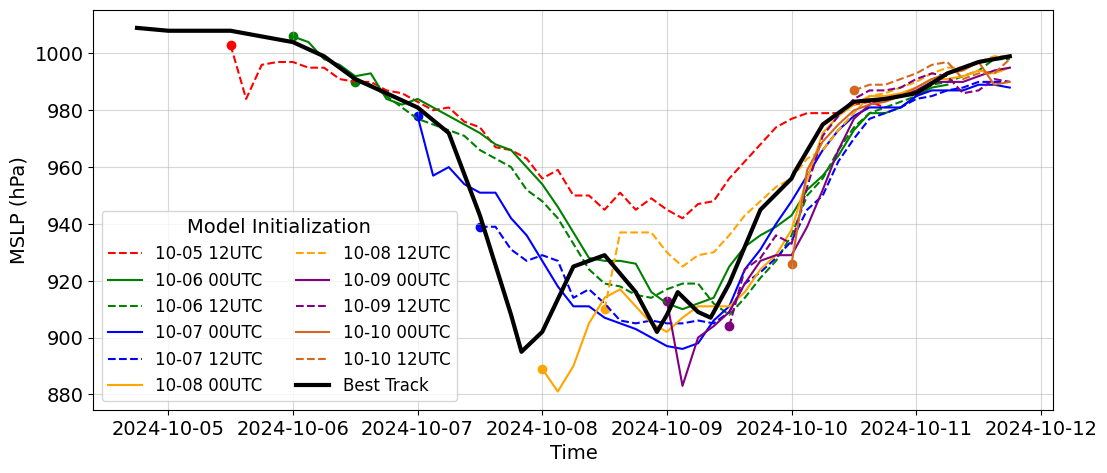

In [40]:
stormStartMSLPs = [list(stormMSLP[key].values())[0] for key in stormMSLP.keys()]

mslpFig = plt.figure(figsize=(12, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

for run in stormMSLP.keys():
  runLabel = f"{run[4:6]}-{run[6:8]} {run[8:10]}UTC"
  mslpPlot = mslpAx.plot(stormMSLP[run].keys(), stormMSLP[run].values(), color=cols[int(run[6:8])], linestyle=linestyles[int(run[8:10])], label=runLabel)
  #if run[6:8] not in doneDays: mslpPlot[0].set_label(f"10-{run[6:8]}")
  #doneDays.append(run[6:8])
  mslpAx.scatter(list(stormMSLP[run].keys())[0], list(stormMSLP[run].values())[0], color=cols[int(run[6:8])])

mslpAx.plot(btDates, tc.mslp, label="Best Track", color="black", linewidth=3)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("MSLP (hPa)")
mslpAx.grid(alpha=0.5)
mslpAx.legend(title="Model Initialization", ncols=2, fontsize=12)

mslpFig.savefig(filepath + "/mslp_allRuns.png")

MSLP Error

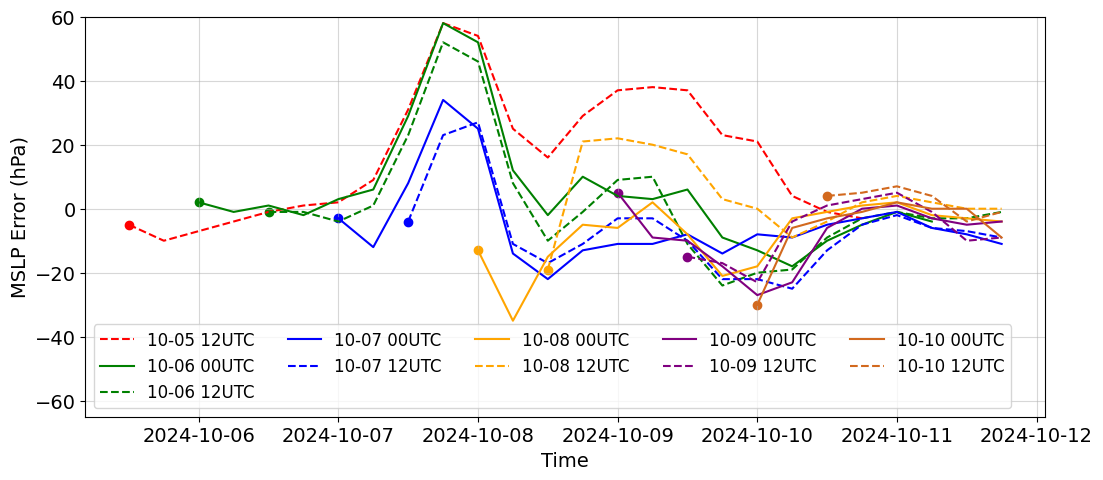

In [41]:
mslpFig = plt.figure(figsize=(12, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

for run in stormMSLP.keys():

  mslpErr = [stormMSLP[run][valid] - tc[tc.time==str(valid)].mslp.iloc[0] for valid in stormMSLP[run].keys() if valid.hour%6==0]
  plotTimes = [valid for valid in stormMSLP[run].keys() if valid.hour%6 == 0]
  runLabel = f"{run[4:6]}-{run[6:8]} {run[8:10]}UTC"
  mslpPlot = mslpAx.plot(plotTimes, mslpErr, color=cols[int(run[6:8])], linestyle=linestyles[int(run[8:10])], label=runLabel)
  mslpAx.scatter(plotTimes[0], mslpErr[0], color=cols[int(run[6:8])])

mslpAx.set_ylim(-65, 60)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("MSLP Error (hPa)")
mslpAx.grid(alpha=0.5)
mslpAx.legend(ncols=5, fontsize=12)

mslpFig.savefig(filepath + "/mslpError.png")

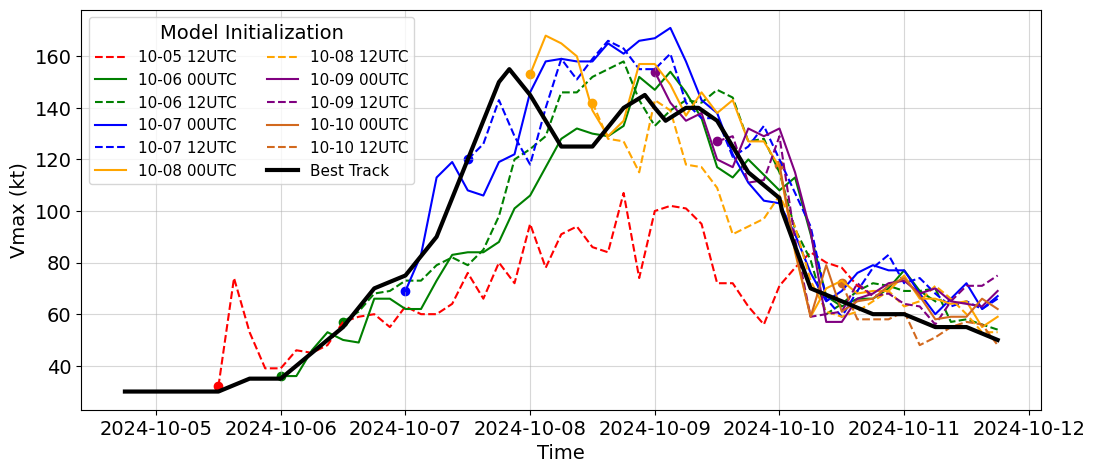

In [65]:
stormStartVmaxs = [list(stormVmax[key].values())[0] for key in stormVmax.keys()]

mslpFig = plt.figure(figsize=(12, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

for run in stormVmax.keys():
  runLabel = f"{run[4:6]}-{run[6:8]} {run[8:10]}UTC"
  mslpPlot = mslpAx.plot(stormVmax[run].keys(), stormVmax[run].values(), color=cols[int(run[6:8])], linestyle=linestyles[int(run[8:10])], label=runLabel)
  #if run[6:8] not in doneDays: mslpPlot[0].set_label(f"10-{run[6:8]}")
  #doneDays.append(run[6:8])
  mslpAx.scatter(list(stormVmax[run].keys())[0], list(stormVmax[run].values())[0], color=cols[int(run[6:8])])

mslpAx.plot(btDates, tc.vmax, label="Best Track", color="black", linewidth=3)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("Vmax (kt)")
mslpAx.grid(alpha=0.5)
mslpAx.legend(title="Model Initialization", ncols=2, fontsize=11)

mslpFig.savefig(filepath + "/vmax_allRuns.png")

In [61]:
stormVmax.keys()

dict_keys(['2024100512', '2024100600', '2024100612', '2024100700', '2024100712', '2024100800', '2024100812', '2024100900', '2024100912', '2024101000', '2024101012'])

Vmax Error

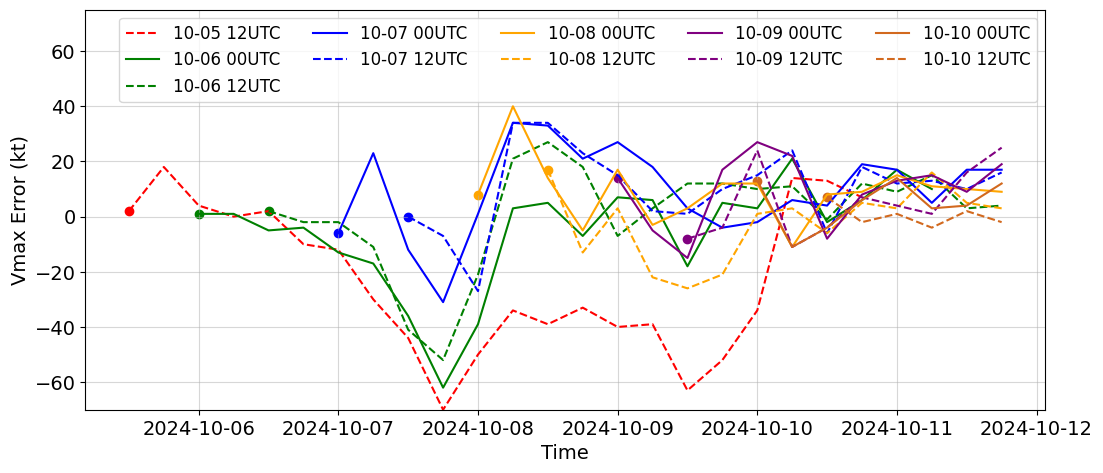

In [49]:
vmaxFig = plt.figure(figsize=(12, 5))
vmaxAx = vmaxFig.add_axes([0.1,0.1,0.8,0.8])

for run in stormVmax.keys():

  vmaxErr = [stormVmax[run][valid] - tc[tc.time==str(valid)].vmax.iloc[0] for valid in stormVmax[run].keys() if valid.hour%6==0]
  plotTimes = [valid for valid in stormVmax[run].keys() if valid.hour%6 == 0]
  runLabel = f"{run[4:6]}-{run[6:8]} {run[8:10]}UTC"
  vmaxPlot = vmaxAx.plot(plotTimes, vmaxErr, color=cols[int(run[6:8])], linestyle=linestyles[int(run[8:10])], label=runLabel)
  vmaxAx.scatter(plotTimes[0], vmaxErr[0], color=cols[int(run[6:8])])

vmaxAx.set_ylim(-70, 75)
vmaxAx.set_xlabel("Time")
vmaxAx.set_ylabel("Vmax Error (kt)")
vmaxAx.grid(alpha=0.5)
vmaxAx.legend(ncols=5, fontsize=12)

vmaxFig.savefig(filepath + "/vmaxError.png")

Vmax and MSLP error with lead time

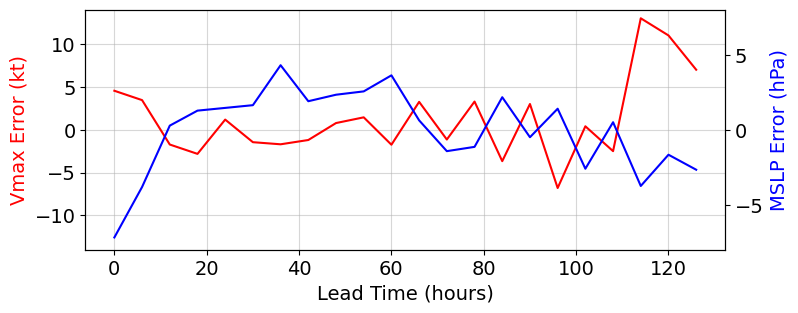

In [37]:
vmaxErr = {t:[] for t in np.arange(0, 127, 6)}
mslpErr = {t:[] for t in np.arange(0, 127, 6)}

for run in stormVmax.keys():
  for valid in stormVmax[run].keys():
    if valid.hour%6==0:
      leadTime = valid - dt.strptime(run, "%Y%m%d%H")
      vmaxErr[int(leadTime.total_seconds()/3600)].append(stormVmax[run][valid] - tc[tc.time==str(valid)].vmax.iloc[0])
      mslpErr[int(leadTime.total_seconds()/3600)].append(stormMSLP[run][valid] - tc[tc.time==str(valid)].mslp.iloc[0])

leadTimeFig = plt.figure(figsize=(8, 3))
vmaxAx = leadTimeFig.add_axes([0.1,0.1,0.8,0.8])
mslpAx = vmaxAx.twinx()

vmaxAx.plot(vmaxErr.keys(), [np.mean(err) for err in vmaxErr.values()], color="red")
mslpAx.plot(vmaxErr.keys(), [np.mean(err) for err in mslpErr.values()], color="blue")

vmaxAx.set_ylim(-14, 14)
mslpAx.set_ylim(-8, 8)
vmaxAx.set_xlabel("Lead Time (hours)")
vmaxAx.set_ylabel("Vmax Error (kt)", color="red")
mslpAx.set_ylabel("MSLP Error (hPa)", color="blue")
vmaxAx.grid(alpha=0.5)
#leadTimeFig.legend(loc="upper center")

Plot model tracks

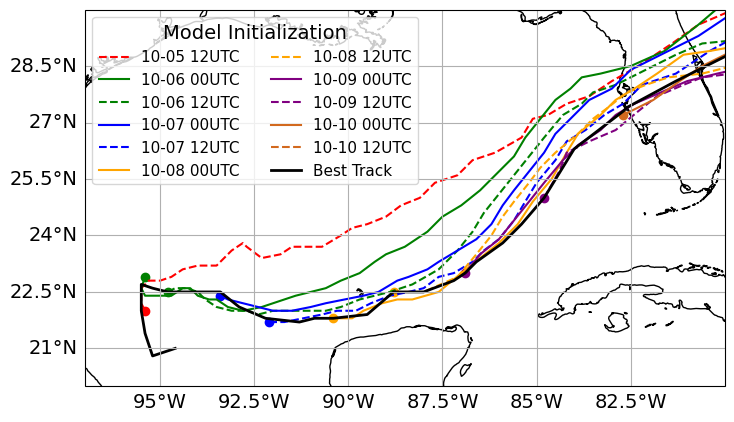

In [53]:
trackFig = plt.figure(figsize=(8, 5))
trackAx = trackFig.add_axes([0.1,0.1,0.8,0.8], projection=ccrs.PlateCarree())

for run in stormLat.keys():

  runLabel = f"{run[4:6]}-{run[6:8]} {run[8:10]}UTC"
  trackPlot = trackAx.plot(stormLon[run].values(), stormLat[run].values(), linestyle=linestyles[int(run[8:10])], label=runLabel, color=cols[int(run[6:8])])
  trackAx.scatter(list(stormLon[run].values())[0], list(stormLat[run].values())[0], color=cols[int(run[6:8])])

trackAx.plot(tc.lon, tc.lat, color="black", linewidth=2, label="Best Track")

trackAx.legend(title="Model Initialization", ncols=2, fontsize=11)
trackAx.set_extent([-97, -80, 20, 30])
trackAx.add_feature(cft.COASTLINE)
trackAx.add_feature(cft.BORDERS)
trackAx.gridlines(draw_labels=["left", "bottom"])

Track errors

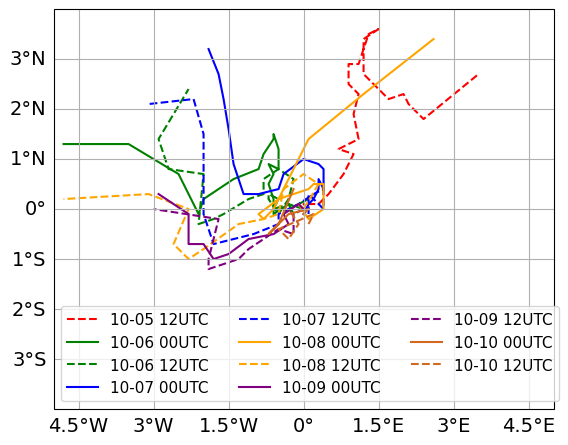

In [52]:
trackFig = plt.figure(figsize=(8, 5))
trackAx = trackFig.add_axes([0.1,0.1,0.8,0.8], projection=ccrs.PlateCarree())

for run in stormLat.keys():

  latErr = [stormLat[run][valid] - tc[tc.time==str(valid)].lat.iloc[0] for valid in stormVmax[run].keys() if valid.hour%6==0]
  lonErr = [stormLon[run][valid] - tc[tc.time==str(valid)].lon.iloc[0] for valid in stormVmax[run].keys() if valid.hour%6==0]
  plotTimes = [valid for valid in stormVmax[run].keys() if valid.hour%6 == 0]

  runLabel = f"{run[4:6]}-{run[6:8]} {run[8:10]}UTC"
  trackPlot = trackAx.plot(lonErr, latErr, linestyle=linestyles[int(run[8:10])], label=runLabel, color=cols[int(run[6:8])])

trackAx.legend(ncols=3, fontsize=11)
trackAx.set_extent([-5, 5, -4, 4])
trackAx.gridlines(draw_labels=["left", "bottom"])